# EfficientNetV2-S 皮肤疾病分类模型训练

本notebook实现了基于EfficientNetV2-S的23类皮肤疾病分类任务，使用DermNet数据集进行训练。

## 1. 导入必要的库和模块

导入深度学习训练所需的所有库，包括PyTorch、torchvision、transformers、数据处理和可视化库。

In [17]:
import json
import os
import time
import warnings
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import timm
from tqdm import tqdm

warnings.filterwarnings('ignore')

## 2. 定义数据集类 DermNetDataset

创建自定义的PyTorch数据集类，用于加载和预处理DermNet皮肤疾病图像数据。

In [18]:
class DermNetDataset(Dataset):
    """Custom dataset for DermNet skin disease images"""
    
    def __init__(self, dataframe: pd.DataFrame, data_root: str, transform=None, is_training: bool = True):
        self.dataframe = dataframe
        self.data_root = Path(data_root)
        self.transform = transform
        self.is_training = is_training
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = self.data_root / row['image_path']
        
        # Load image
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a black image if loading fails
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return image, label

## 3. 定义 EfficientNetV2 分类器模型

构建基于EfficientNetV2的深度学习分类器，包括预训练模型加载和自定义分类头。

In [19]:
import timm

class EfficientNetV2Classifier(nn.Module):
    """EfficientNetV2-S based classifier for skin disease classification"""
    
    def __init__(self, num_classes: int = 23, freeze_layers: int = 150):
        super(EfficientNetV2Classifier, self).__init__()
        
        # Load pre-trained EfficientNetV2-S using timm
        self.backbone = timm.create_model(
            "tf_efficientnetv2_s.in21k_ft_in1k", 
            pretrained=True,
            num_classes=num_classes
        )
        
        # Freeze early layers for transfer learning
        self._freeze_layers(freeze_layers)
        
        # Replace the classifier head with a custom one
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def _freeze_layers(self, freeze_layers: int):
        """Freeze the first N layers of the backbone"""
        if freeze_layers > 0:
            # Count total parameters
            total_params = sum(1 for _ in self.backbone.parameters())
            
            # Freeze feature extraction layers
            params = list(self.backbone.parameters())
            for i, param in enumerate(params[:freeze_layers]):
                param.requires_grad = False
            print(f"Frozen first {freeze_layers} layers out of {total_params} total parameters")
    
    def forward(self, x):
        return self.backbone(x)

## 4. 定义数据预处理和增强函数

实现训练和验证阶段的数据预处理管道，包括图像变换、数据增强和标准化。

In [20]:
def get_transforms(input_size: int = 384, is_training: bool = True):
    """Get data transforms for training and validation - EfficientNetV2-S optimized"""
    
    if is_training:
        return transforms.Compose([
            transforms.Resize((input_size + 32, input_size + 32)),
            transforms.RandomCrop((input_size, input_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

## 5. 实现余弦退火学习率调度器

创建带有热身重启的余弦退火学习率调度器，用于动态调整训练过程中的学习率。

In [21]:
class CosineAnnealingWarmupRestarts(optim.lr_scheduler._LRScheduler):
    """Cosine annealing with warm restarts and warmup"""
    
    def __init__(self, optimizer, first_cycle_steps, cycle_mult=1., max_lr=0.1, min_lr=0.001, 
                 warmup_steps=0, gamma=1., last_epoch=-1):
        self.first_cycle_steps = first_cycle_steps
        self.cycle_mult = cycle_mult
        self.base_max_lr = max_lr
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.gamma = gamma
        
        self.cur_cycle_steps = first_cycle_steps
        self.cycle = 0
        self.step_in_cycle = last_epoch
        
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)
        
        # set lr of each param group according to the specified schedule
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
    
    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + np.cos(np.pi * (self.step_in_cycle-self.warmup_steps) \
                                  / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(np.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## 6. 实现数据加载函数

编写函数来加载训练和测试数据集，包括CSV文件读取和类别权重加载。

In [22]:
def load_data(data_root: str, processed_data_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """Load training and test data"""
    
    # Load processed data
    train_df = pd.read_csv(os.path.join(processed_data_path, 'train.csv'))
    test_df = pd.read_csv(os.path.join(processed_data_path, 'test.csv'))
    
    # Load class weights
    with open(os.path.join(processed_data_path, 'class_weights.json'), 'r') as f:
        class_weights = json.load(f)
    
    # Convert string keys to int
    class_weights = {int(k): v for k, v in class_weights.items()}
    
    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    print(f"Number of classes: {len(class_weights)}")
    
    return train_df, test_df, class_weights

## 7. 实现训练循环函数

实现单个训练轮次的函数，包括前向传播、损失计算、反向传播和参数更新。

In [23]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, 
                optimizer: optim.Optimizer, device: torch.device, epoch: int) -> Tuple[float, float]:
    """Train for one epoch"""
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} Training')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

## 8. 实现验证循环函数

实现单个验证轮次的函数，包括模型评估模式设置和验证指标计算。

In [24]:
def validate_epoch(model: nn.Module, val_loader: DataLoader, criterion: nn.Module, 
                  device: torch.device, epoch: int) -> Tuple[float, float]:
    """Validate for one epoch"""
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Epoch {epoch} Validation')
        
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

## 9. 实现模型评估函数

创建完整的模型评估函数，计算测试集上的准确率、精确率、召回率、F1分数和混淆矩阵。

In [25]:
def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device, 
                  num_classes: int) -> Dict:
    """Evaluate model on test set"""
    
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': all_predictions,
        'labels': all_labels,
        'confusion_matrix': cm.tolist()
    }
    
    return results

## 10. 实现训练历史可视化函数

编写函数来绘制和保存训练过程中的损失和准确率曲线图。

In [26]:
def plot_training_history(history: Dict, save_path: str):
    """Plot and save training history"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss', marker='o')
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## 11. 实现混淆矩阵可视化函数

实现混淆矩阵的可视化函数，使用热力图显示模型在各类别上的分类性能。

In [27]:
def plot_confusion_matrix(cm: np.ndarray, class_names: List[str], save_path: str):
    """Plot and save confusion matrix"""
    
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## 12. 设置训练参数和配置

定义和配置所有训练超参数，包括学习率、批次大小、训练轮数、设备选择等。

In [ ]:
# 训练配置参数
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
config = {
    # 数据参数
    'data_root': '.',
    'processed_data_path': 'processed_data',
    'output_dir': f'models/EfficientNetV2-S_{timestamp}',
    'checkpoint_dir': f'models/EfficientNetV2-S',

    # 模型参数
    'num_classes': 23,
    'freeze_layers': 150,
    'input_size': 384,
    
    # 训练参数
    'epochs': 200,
    'batch_size': 16,
    'learning_rate': 1e-3,
    'min_lr': 1e-6,
    'weight_decay': 1e-4,
    'warmup_epochs': 5,
    'patience': 20,

    # 其他参数
    'num_workers': 0,
    'seed': 42,
    'save_every': 10
}

# 设置随机种子
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 创建输出目录
os.makedirs(config['output_dir'], exist_ok=True)

Using device: cuda


## 13. 加载和准备数据

执行数据加载流程，创建训练和测试数据集，设置数据加载器和类别映射。

In [34]:
# 加载数据
print("Loading data...")
train_df, test_df, class_weights = load_data(config['data_root'], config['processed_data_path'])

# 加载类别映射
with open(os.path.join(config['processed_data_path'], 'category_mapping.json'), 'r') as f:
    category_mapping = json.load(f)
class_names = category_mapping['categories']

print(f"类别名称: {class_names[:5]}...")  # 显示前5个类别

# 创建数据变换
train_transform = get_transforms(config['input_size'], is_training=True)
val_transform = get_transforms(config['input_size'], is_training=False)

# 创建数据集
print("Creating datasets...")
train_dataset = DermNetDataset(train_df, config['data_root'], transform=train_transform, is_training=True)
test_dataset = DermNetDataset(test_df, config['data_root'], transform=val_transform, is_training=False)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, 
                         num_workers=config['num_workers'], pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, 
                        num_workers=config['num_workers'], pin_memory=True)

print(f"训练批次数: {len(train_loader)}")
print(f"测试批次数: {len(test_loader)}")

Loading data...
Training samples: 15557
Test samples: 4002
Number of classes: 23
类别名称: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections']...
Creating datasets...
训练批次数: 973
测试批次数: 251


## 14. 创建模型和优化器

实例化EfficientNetV2分类器模型，创建损失函数、优化器和学习率调度器。

In [35]:
# 创建模型
print("Creating model...")
model = EfficientNetV2Classifier(num_classes=config['num_classes'], freeze_layers=config['freeze_layers'])
model = model.to(device)

# 创建带有类别权重的损失函数
class_weights_tensor = torch.tensor([class_weights[i] for i in range(config['num_classes'])], 
                                   dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# 创建优化器
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# 创建学习率调度器
steps_per_epoch = len(train_loader)
total_steps = config['epochs'] * steps_per_epoch
warmup_steps = config['warmup_epochs'] * steps_per_epoch

scheduler = CosineAnnealingWarmupRestarts(
    optimizer,
    first_cycle_steps=total_steps,
    max_lr=config['learning_rate'],
    min_lr=config['min_lr'],
    warmup_steps=warmup_steps
)

print(f"模型参数数量: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Creating model...
Frozen first 150 layers out of 452 total parameters
模型参数数量: 18587583


加载最优模型权重（如果存在）

In [36]:
# 加载最优模型权重
print("Loading best model weights...")
best_model_path = os.path.join(config['checkpoint_dir'], 'best_model_efficientnet_v2.pth')

if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # 如果检查点中包含调度器状态，则加载
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['val_acc']
    print(f"Successfully loaded model from epoch {start_epoch} with validation accuracy {best_val_acc:.2f}%")
else:
    print("No existing model found, starting from scratch")
    start_epoch = 0
    best_val_acc = 0.0

Loading best model weights...
Successfully loaded model from epoch 50 with validation accuracy 58.42%


## 15. 执行模型训练

运行完整的训练循环，包括多个训练轮次的执行、最佳模型保存和训练历史记录。

In [ ]:
# 训练历史记录
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

best_val_acc = 0.0
best_epoch = 0
patience_counter = 0

print("Starting training...")
start_time = time.time()

for epoch in range(1, config['epochs'] + 1):
    print(f"\nEpoch {epoch}/{config['epochs']}")
    print("-" * 50)
    
    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    
    # 验证
    val_loss, val_acc = validate_epoch(model, test_loader, criterion, device, epoch)
    
    # 更新学习率
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 保存历史记录
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config
        }, os.path.join(config['output_dir'], 'best_model_efficientnet_v2.pth'))
        print(f"New best model saved! Val Acc: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1

    # 早停
    if patience_counter >= config['patience']:
        print("Early stopping triggered")
        break

    # 定期保存检查点
    if epoch % config['save_every'] == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config
        }, os.path.join(config['output_dir'], f'checkpoint_epoch_{epoch}_efficientnet_v2.pth'))

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/3600:.2f} hours")
print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")

Starting training...

Epoch 1/200
--------------------------------------------------


Epoch 1 Training:   4%|▍         | 37/973 [00:14<06:13,  2.51it/s, Loss=0.6876, Acc=71.45%]


KeyboardInterrupt: 

## 16. 保存和评估最终模型

保存训练好的模型，在测试集上进行最终评估，生成性能报告和可视化结果。

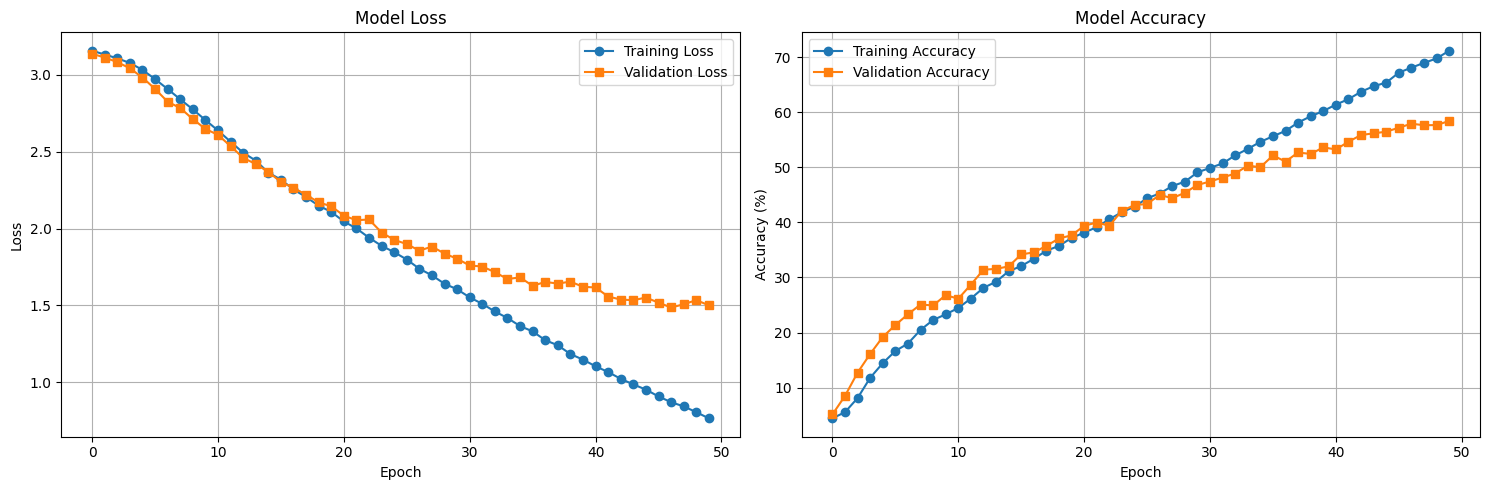

In [ ]:
# 保存最终模型
torch.save({
    'epoch': config['epochs'],
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'val_acc': val_acc,
    'val_loss': val_loss,
    'config': config
}, os.path.join(config['output_dir'], 'final_model_efficientnet_v2.pth'))

# 保存训练历史
with open(os.path.join(config['output_dir'], 'training_history_efficientnet_v2.json'), 'w') as f:
    json.dump(history, f, indent=2)

# 绘制训练历史
plot_training_history(history, os.path.join(config['output_dir'], 'training_history_efficientnet_v2.png'))

## 17. 加载最佳模型进行最终评估

加载保存的最佳模型，在测试集上进行完整评估并生成详细的性能报告。


Loading best model for final evaluation...
Evaluating on test set...


Testing: 100%|██████████| 251/251 [00:39<00:00,  6.42it/s]



=== 最终测试结果 ===
Accuracy: 0.5842
Precision: 0.6188
Recall: 0.5842
F1-Score: 0.5871


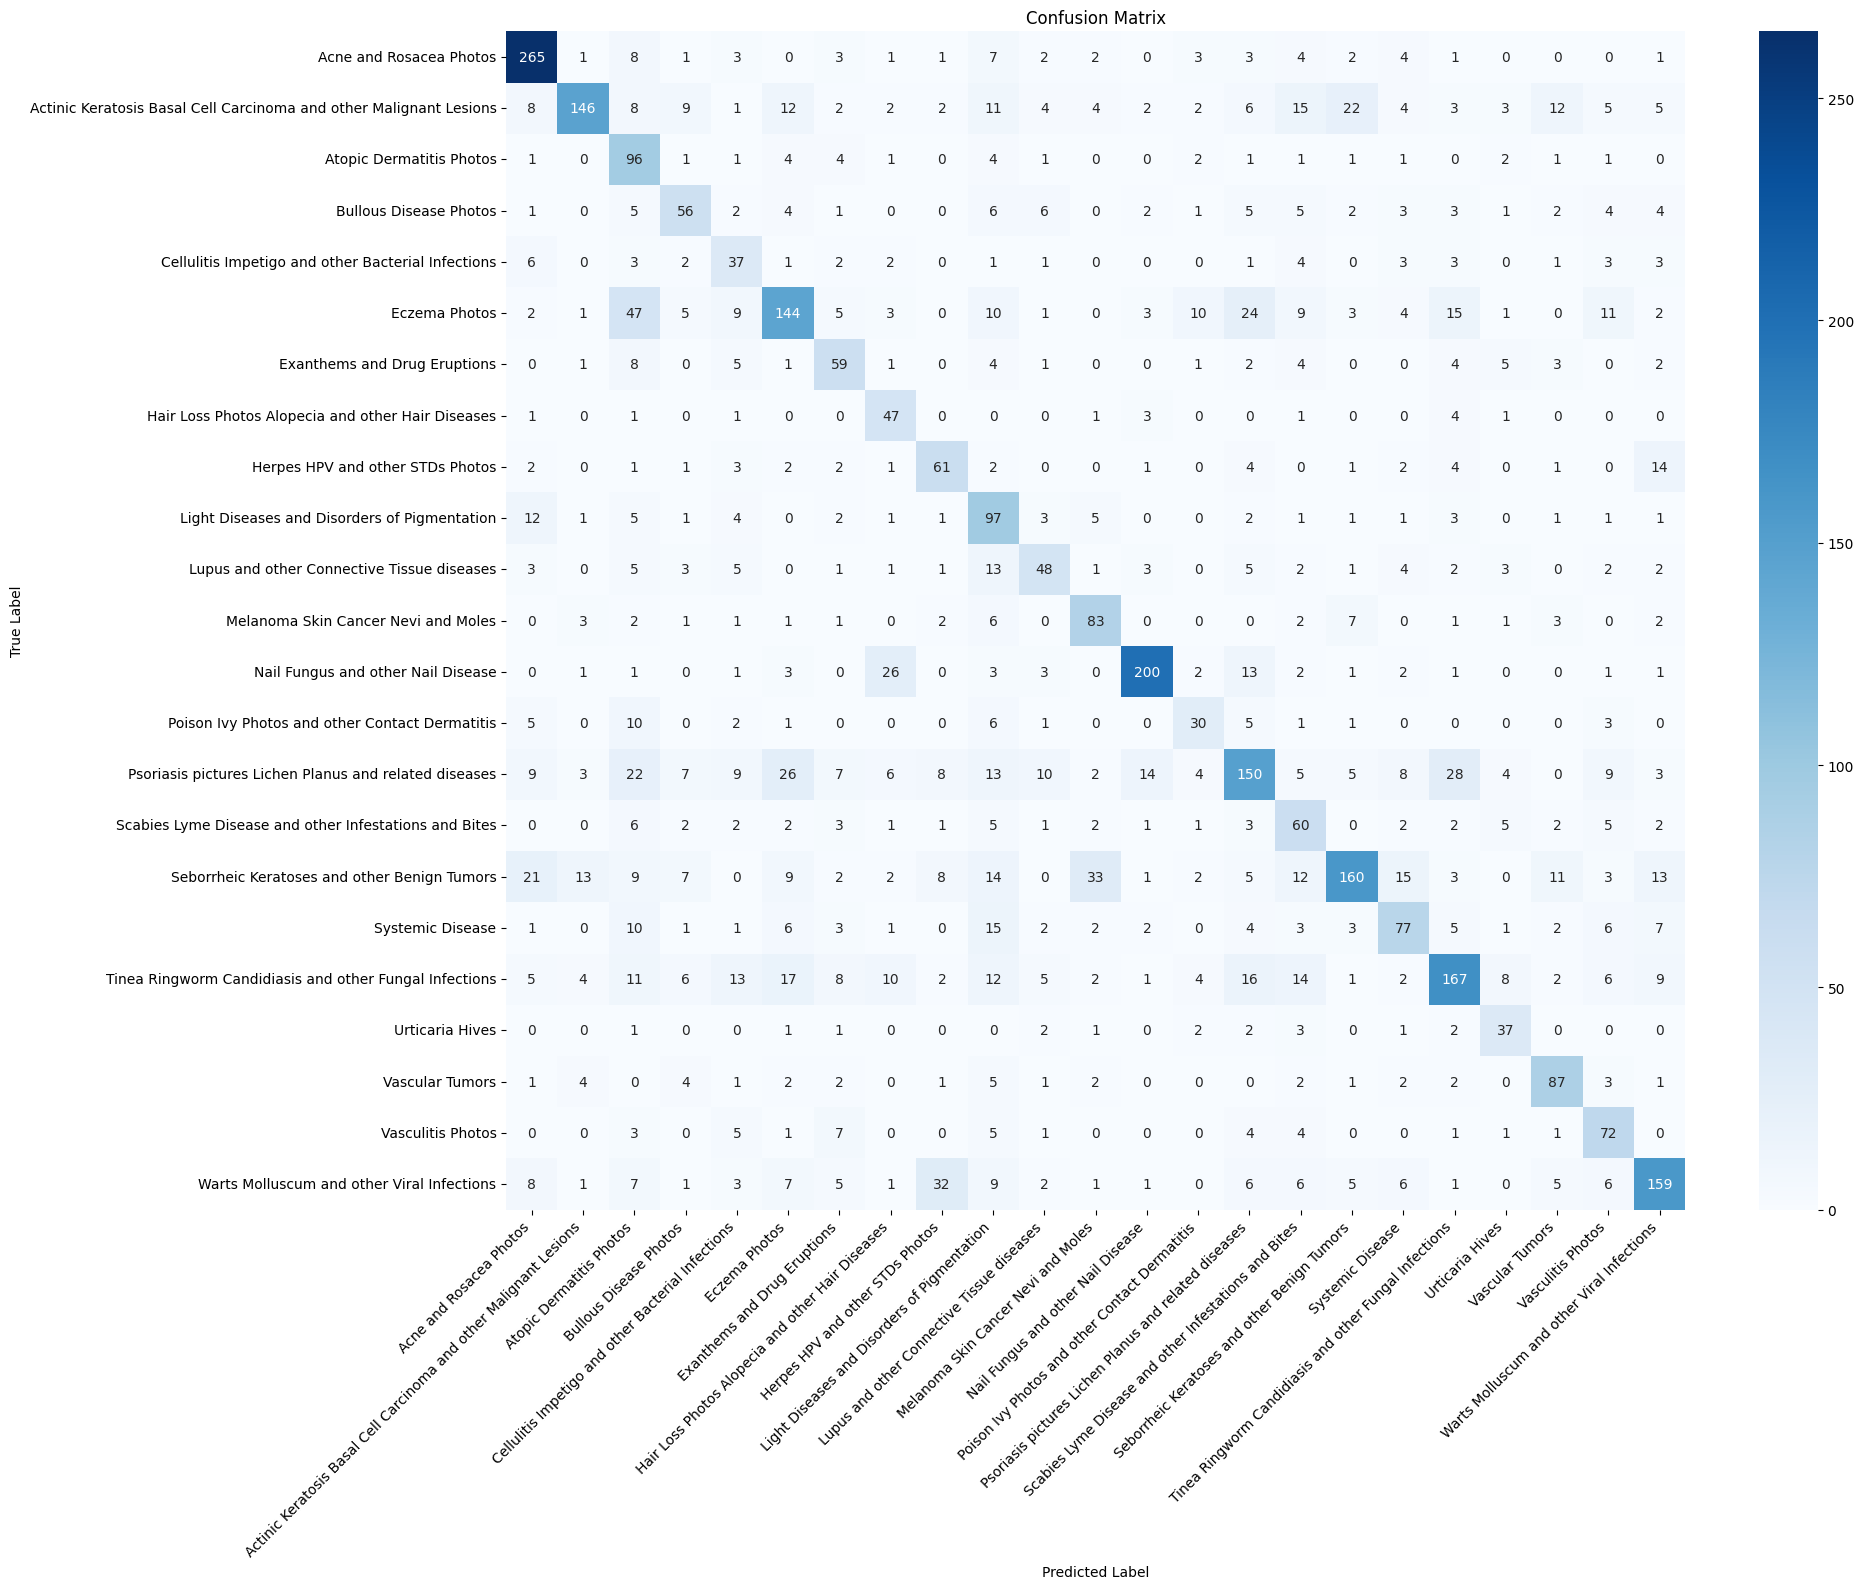


All results saved to models/EfficientNetV2-S

=== 训练完成！===


In [ ]:
# 加载最佳模型进行最终评估
print("\nLoading best model for final evaluation...")
checkpoint = torch.load(os.path.join(config['output_dir'], 'best_model_efficientnet_v2.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

# 最终评估
print("Evaluating on test set...")
test_results = evaluate_model(model, test_loader, device, config['num_classes'])

print(f"\n=== 最终测试结果 ===")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"F1-Score: {test_results['f1_score']:.4f}")

# 保存测试结果
with open(os.path.join(config['output_dir'], 'test_results_efficientnet_v2.json'), 'w') as f:
    # 转换numpy数组为列表以便JSON序列化
    test_results_json = {
        'accuracy': test_results['accuracy'],
        'precision': test_results['precision'],
        'recall': test_results['recall'],
        'f1_score': test_results['f1_score'],
        'confusion_matrix': test_results['confusion_matrix']
    }
    json.dump(test_results_json, f, indent=2)

# 绘制混淆矩阵
plot_confusion_matrix(
    np.array(test_results['confusion_matrix']), 
    class_names, 
    os.path.join(config['output_dir'], 'confusion_matrix_efficientnet_v2.png')
)

print(f"\nAll results saved to {config['output_dir']}")
print("\n=== 训练完成！===")